In [70]:
# imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import numpy as np
import random
import joblib
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing
from collections import Counter
from boruta import BorutaPy
from IPython import display
from pyteomics import electrochem, mass, parser
%matplotlib inline
pd.options.display.max_rows = 10
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 6
np.random.seed(0)

## Variables

In [71]:
# positive (peptide) classes
peptides = ['EIYKRWII', 'FLKEKGGL']

# negative (control) class
negative = 'Control'

# all classes
classes = peptides + [negative]

# V and J gene as list
genes = ['V_gene', 'J_gene']

# amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',]

# physicochemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchems = {'basicity':basicity, 'hydrophobicity':hydrophobicity,
             'helicity':helicity, 'mutation stability':mutation_stability}


## Functions

In [72]:
def split_rows(df, column, symbol):
    
    ''' Given a dataframe, the name of a column in the dataframe and a symbol to split on:
    Split rows in two rows if that row's column value contains the symbol to split on.
    Each new row is identical to the original except for the column value which is replaced by one of its split parts.
    '''
    
    s = df[column].str.split(symbol, expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2[column] = s.values
    return df2

def fix_gene_format(gene_string):
    
    ''' Make format in which V- and J-genes are encoded uniform and reduce to family level. '''
    if gene_string == 'unresolved':
        return gene_string
    if '-' in gene_string:
        gene_string = gene_string.split('-')[0]
    if len(gene_string) != 2:
        gene_string = '0'+gene_string
    return gene_string

def calc_average_property(sequence, physchem):
    
    return np.mean([physchem[x] for x in sequence])

def create_indices(pos_class, neg_class, repeats):
    
    indices = []
    
    # do kfold split of positive data to generate training and test index sets for positive data
    ss = model_selection.ShuffleSplit(n_splits=repeats, test_size = 1/repeats)
    pos_indices = ss.split((y[y==pos_class].index))

    # for each training and test set of indices on the positive data
    # generate a set of training and test indices on the negative data that is 10 times as large
    for pos_train_index, pos_test_index in pos_indices:
        # generate negative indices 
        mysampler = RandomSampler(n_pos_samples=0, n_neg_samples=10*(len(pos_train_index)+len(pos_test_index)),\
                                  k_samples=1)
        neg_indices = mysampler.split(y, pos_label=pos_class, neg_label=neg_class)[0][1]

        # split into negative training and negative test indices
        neg_train_index = neg_indices[0:10*len(pos_train_index)]
        neg_test_index = neg_indices[10*len(pos_train_index):]

        # combine with positive indices to make all train and all test indices
        train_index = list(pos_train_index)+list(neg_train_index)
        test_index = list(pos_test_index)+list(neg_test_index)

        indices.append([pos_class, train_index, test_index])
    
    return indices

## Reading and parsing input data

**TODO**: write explanation of source of data and preprocessing of it

In [73]:
# read peptide data
peptide_data = pd.read_csv('data.csv')
# J_genes don't contain double genes in the peptide dataset => only split on V_gene
peptide_data = split_rows(peptide_data, 'V_gene', '/') 

# read control data; splits were already done during processing of immuneaccess data
control_data = pd.read_csv('control_data.csv')

# combine control and peptide data
data = pd.concat([peptide_data, control_data], ignore_index=True)
for gene in genes:
    data[gene] = data[gene].apply(lambda x: fix_gene_format(x))

# show data
for target in classes:
    display.display(data[data['HLA_peptide'] == target])

,V_gene,CDR3_sequence,J_gene,HLA_peptide
0,27,CASSPNGDRVFDQPQHF,01,EIYKRWII
1,09,CASSVVGDGRETQYF,02,EIYKRWII
2,09,CASSEGQGTTYEQYF,02,EIYKRWII
3,02,CASSEAATGRGNQPQHF,01,EIYKRWII
4,09,CASSVLHGRQETQYF,02,EIYKRWII
...,...,...,...,...
137,28,CASSLPPPGIKGELFF,02,EIYKRWII
138,07,CASSTLPGTPRNEQYF,02,EIYKRWII
139,09,CASSVGGDARETQYF,02,EIYKRWII
140,02,CASSASTKDTQYF,02,EIYKRWII


,V_gene,CDR3_sequence,J_gene,HLA_peptide
142,02,CASSVLAGLGNEQFF,02,FLKEKGGL
143,02,CASSVLAGHGNGQFF,02,FLKEKGGL
144,11,CASSLLAGLTDTQYF,02,FLKEKGGL
145,02,CASSVLAGLGNEQFF,02,FLKEKGGL
146,02,CASSVLAGLGNEQFF,02,FLKEKGGL
...,...,...,...,...
232,07,CASSLAPGTSGSPYNEQFF,02,FLKEKGGL
233,14,CASSLGTGIANYGYTF,02,FLKEKGGL
234,14,CASSLGTGIANYGYTF,02,FLKEKGGL
235,24,CATKGTGLYNEQFF,02,FLKEKGGL


,V_gene,CDR3_sequence,J_gene,HLA_peptide
237,14,CASSPGESYEQYF,02,Control
238,14,CASSPSYRGEQYF,02,Control
239,14,CASSQWGTYEQYF,02,Control
240,14,CASSQTQFQPQHF,01,Control
241,14,CASSHLGGDEQFF,02,Control
...,...,...,...,...
58141,29,CSASTSGPETGNEQFF,02,Control
58142,29,CSASLVDAPMVNEQFF,02,Control
58143,29,CSAGTGGLGSNQPQHF,01,Control
58144,29,CTIARGTPLSTDTQYF,02,Control


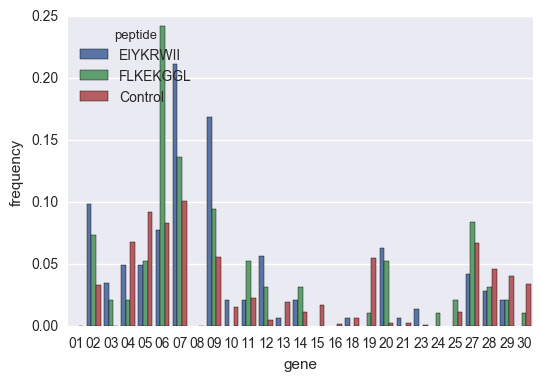

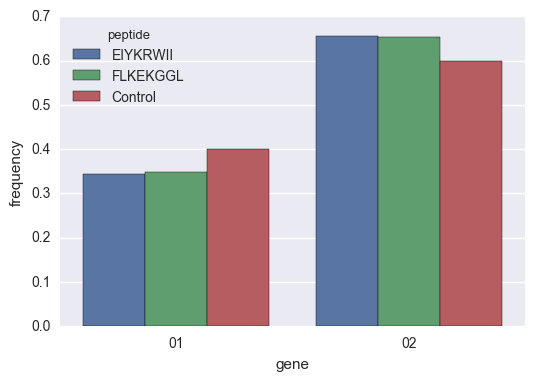

In [74]:
# show V_gene and J_gene usage
for gene in genes:
    bardfs = []
    for target in classes:
        bardfs.append(pd.DataFrame({'gene': data[(data['HLA_peptide']==target) & (data[gene]!='unresolved')][gene].value_counts(sort=False).index,
                              'count': data[(data['HLA_peptide']==target) & (data[gene]!='unresolved')][gene].value_counts(sort=False).values/data[data['HLA_peptide']==target][gene].value_counts(sort=False).values.sum(),
                              'peptide': [target for _ in data[(data['HLA_peptide']==target) & (data[gene]!='unresolved')][gene].value_counts(sort=False).index]}))
    bardf = pd.concat(bardfs)
    plt.figure()
    sns.barplot(x='gene', y='count', hue='peptide', data=bardf)
    plt.ylabel('frequency')

## Feature generation

Create features for each sequence based on:
* V-gene usage (one-hot)
* J-gene usage (one-hot)
* Sequence length (numerical)
* Amino acid count (numerical)
* Average amino acid properties (basicity, hydrophobicity, helicity, mutational stability) (numerical)
* Position specific amino acid properties (numerical)
* Position specific amino acid presence (one-hot)

In [75]:
def create_feature_matrix(data):

    # non-positional features
    nonpos_features_list = []

    # one-hot encode V- and J-gene
    onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
    encoded_genes = pd.DataFrame(
            onehot_encoder.fit_transform(data[['V_gene', 'J_gene']].to_dict(orient='records')),
            columns=onehot_encoder.feature_names_)

    nonpos_features_list.append(pd.Series(data['CDR3_sequence'].apply(lambda x: len(x)), name='length'))

    # amount of each amino acid present in sequence
    aa_counts = []
    for aa in amino_acids:
        aa_counts.append(pd.Series(data['CDR3_sequence'].apply(lambda x: x.count(aa)), name='{} count'.format(aa)))
    nonpos_features_list.append(pd.concat(aa_counts, axis=1))

    # average physicochemical property value of sequence
    average_physchems = []
    for physchem_name, physchem in physchems.items():
        average_physchems.append(pd.Series(data['CDR3_sequence'].apply(lambda x: calc_average_property(x, physchem)), 
                                           name='average {}'.format(physchem_name)))
    nonpos_features_list.append(pd.concat(average_physchems, axis=1))
    
    # concatenate all non-positional features
    nonpos_features = pd.concat(nonpos_features_list, axis=1)
    
    # positional features
    pos_features_list = []
    
    # amino acid occurence and physicochemical properties at a given position from the center
    pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_pI, pos_mutation = [[] for _ in range(6)]
    for sequence in data['CDR3_sequence']:
        length = parser.length(sequence)
        start_pos = -1 * (length // 2)
        pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                    list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))

        pos_aa.append({'pos_{}_{}'.format(pos, aa): 1
                       for pos, aa in zip(pos_range, sequence)})
        pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                          for pos, aa in zip(pos_range, sequence)})
        pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                       for pos, aa in zip(pos_range, sequence)})
        pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                             for pos, aa in zip(pos_range, sequence)})

    pos_features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))
    
    # concatenate all positional features
    pos_features = pd.concat(pos_features_list, axis=1)
    reindex_dict = {}
    for i, j in zip(pos_features.index, nonpos_features.index):
        reindex_dict[i]=j
    pos_features = pos_features.rename(index=reindex_dict)
    
    return pd.concat([nonpos_features, pos_features], axis=1)

In [76]:
# split dataframe into frame containing raw data (and use it to create features) and frame containing target
X_raw = data.drop('HLA_peptide', axis=1)
X_features = create_feature_matrix(X_raw)
y = data['HLA_peptide']

## Data subsampling

In [77]:
class RandomSampler():
    
    ''' Generates k_samples tuples of indices to split dataframe into respectively:
    1) a dataframe containing n_pos_samples different positive samples
    2) a dataframe containing n_neg_samples different negative samples.
    Within each tuple, indices are drawn randomly without replacement.
    Between tuples, indices can reoccur. '''
    
    def __init__(self, n_pos_samples, n_neg_samples, k_samples = 10):
        
        # number of positive indices to generate
        self.n_pos_samples = n_pos_samples
        # number of negative indices to generate
        self.n_neg_samples = n_neg_samples
        # number of tuple indices to return
        self.k_samples = k_samples
        
    def split(self, y, pos_label, neg_label):
        
        indices = []
        for k in range(self.k_samples):
            all_pos_indices = y[y==pos_label].index
            selected_pos_indices = np.random.choice(all_pos_indices, size=self.n_pos_samples, replace=False)
            all_neg_indices = y[y==neg_label].index
            selected_neg_indices = np.random.choice(all_neg_indices, size=self.n_neg_samples, replace=False)
            indices.append((selected_pos_indices, selected_neg_indices))
        return indices

## Classification

In [78]:
# run a single iteration of the predictor (extracted to a method for multithreaded computation)
def run_predictor(predictor, X, y, train_index, test_index):
    
    y = preprocessing.LabelEncoder().fit_transform(y)
    
    X_train = X.loc[train_index].values
    X_test = X.loc[test_index].values
    y_train, y_test = y[train_index], y[test_index]
    
    # train the predictor pipeline
    try:
        predictor.fit(X_train, y_train)
    except ValueError:
        print('{}\n{}\n{}\n{}\n'.format(X_train.shape, X_test.shape, len(y_train), len(y_test)))
    
    # extract the relevant feature importances
    importances = np.zeros(X_train.shape[1], float)
    importances[predictor.named_steps['feature_selection'].support_] =\
        predictor.named_steps['classification'].feature_importances_
    
    # return the predictions to evaluate the performance
    predictions_proba = predictor.predict_proba(X_test)[:, 1]
    
    return (y_test, np.array(predictions_proba > 0.5, np.int)),\
           (y_test, predictions_proba),\
           importances

In [79]:
# number of trees to use by RF
n_trees = 200

# create a prediction pipeline consisting of feature selection and classification
classifier = ensemble.RandomForestClassifier(n_trees, n_jobs=-1, random_state=0, class_weight='balanced')
feature_selection = BorutaPy(ensemble.ExtraTreesClassifier(n_jobs=-1), n_estimators='auto', random_state=0)

predictor = pipeline.Pipeline([('feature_selection', feature_selection), ('classification', classifier)])

In [80]:
peptide_results = []

for peptide in peptides:
    
    indices = create_indices(pos_class=peptide, neg_class=negative, repeats=10)
    
    # turn off numpy RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        result = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_predictor)
                                                       (predictor, X_features, y, train_index, test_index)
                                                       for pep, train_index, test_index in indices if pep == peptide))

        predictions = result[:, 0]
        predictions_proba = result[:, 1]
        feature_importances = result[:, 2]
        peptide_results.append([peptide, predictions, predictions_proba, feature_importances])

Classification accuracy = 94.00% ± 0.99%


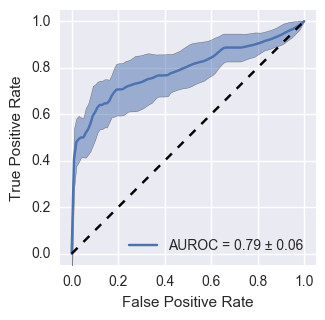

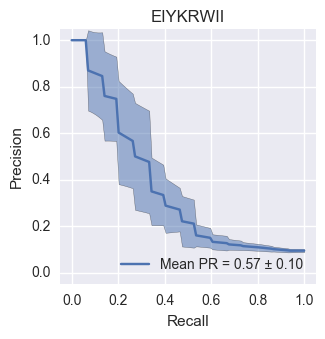

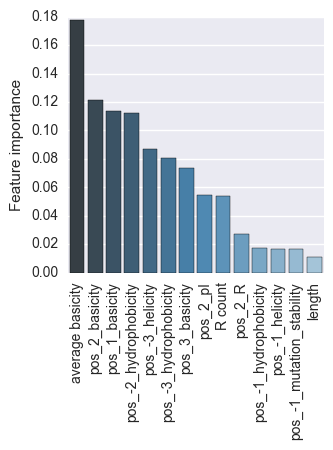

average basicity             0.177413
pos_2_basicity               0.121632
pos_1_basicity               0.113336
pos_-2_hydrophobicity        0.112491
pos_-3_helicity              0.086912
                               ...   
pos_2_R                      0.026955
pos_-1_hydrophobicity        0.017141
pos_-1_helicity              0.016723
pos_-1_mutation_stability    0.016394
length                       0.011175
Name: Feature importances, dtype: float64
Classification accuracy = 88.82% ± 4.95%


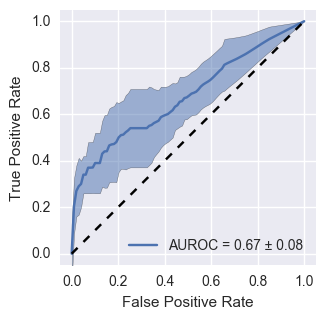

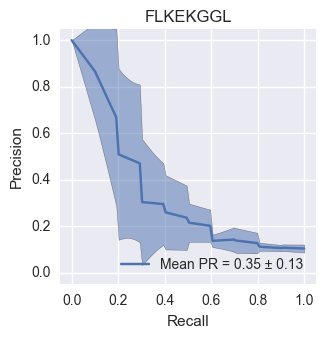

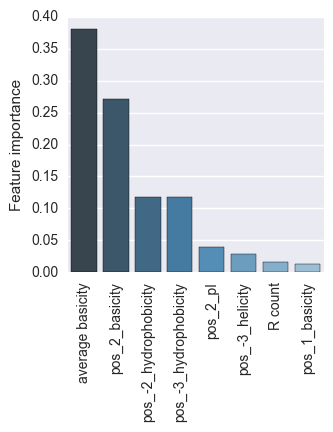

average basicity         0.380007
pos_2_basicity           0.271316
pos_-2_hydrophobicity    0.117669
pos_-3_hydrophobicity    0.117373
pos_2_pI                 0.040217
pos_-3_helicity          0.028403
R count                  0.016181
pos_1_basicity           0.012959
Name: Feature importances, dtype: float64


In [81]:
for peptide, predictions, predictions_proba, feature_importances in peptide_results:
    
    # evaluate the performance of the prediction pipeline
    # accuracy
    accuracy_mean = np.mean([metrics.accuracy_score(y_test, y_pred)
                             for y_test, y_pred in predictions])
    accuracy_std = np.std([metrics.accuracy_score(y_test, y_pred)
                           for y_test, y_pred in predictions])

    # AUC and average precision
    auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred)
                        for y_test, y_pred in predictions_proba])
    auc_std = np.std([metrics.roc_auc_score(y_test, y_pred)
                      for y_test, y_pred in predictions_proba])
    avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred)
                                  for y_test, y_pred in predictions_proba])
    avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred)
                                for y_test, y_pred in predictions_proba])
    avg_precision_inverted_mean = np.mean([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                           for y_test, y_pred in predictions_proba])
    avg_precision_inverted_std = np.std([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                         for y_test, y_pred in predictions_proba])

    # mean and standard deviation of ROC and precision-recall curves
    interval = np.linspace(0, 1, 100)
    tprs, precisions, precisions_inverted = [], [], []
    for y_test, y_pred in predictions_proba:
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
        tprs.append(np.interp(interval, fpr, tpr))

        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        precisions.append(np.interp(interval, recall[::-1], precision))

        # inverted precision
        precision_inverted, recall_inverted, _ = metrics.precision_recall_curve(1 - y_test, 1 - y_pred)
        precisions_inverted.append(np.interp(interval, recall_inverted[::-1], precision_inverted))

    tpr_mean = np.mean(tprs, axis=0)
    tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
    tpr_std = np.std(tprs, axis=0)
    precision_mean = np.mean(precisions, axis=0)
    precision_std = np.std(precisions, axis=0)
    precision_inverted_mean = np.mean(precisions_inverted, axis=0)
    precision_inverted_std = np.std(precisions_inverted, axis=0)

    # print accuracy
    print('Classification accuracy = {:.2%} ± {:.2%}'.format(accuracy_mean, accuracy_std))

    # plot ROC curve
    width, height = 3.3, 3.3

    plt.figure(figsize=(width, height))

    plt.plot(interval, tpr_mean, label='AUROC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
    plt.fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc='lower right')

    plt.gca().set_aspect('equal', adjustable='box')

    plt.savefig('AUC.pdf', bbox_inches='tight', dpi=600)

    plt.show()
    plt.close()

    # plot precision-recall curve
    plt.figure(figsize=(width, height))
    plt.plot(interval[::-1], precision_mean,
             label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
    plt.fill_between(interval[::-1], precision_mean - precision_std, precision_mean + precision_std,
                     alpha=0.5)
    plt.title(peptide)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')

    plt.savefig('PR.pdf', bbox_inches='tight', dpi=600)

    plt.show()
    plt.close()
    
    feat_import_s = pd.Series(np.mean(feature_importances, axis=0),
                              index=X_features.columns.values, name='Feature importances')
    significant_features = feat_import_s[feat_import_s > 0.01].sort_values(ascending=False)

    plt.figure(figsize=(width, height))

    sns.barplot(x=significant_features.index.values, y=significant_features, palette='Blues_d')

    plt.xticks(rotation='vertical', fontsize=10)
    plt.ylabel('Feature importance')

    plt.savefig('feature_importance.pdf', bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()
    print(significant_features)

## Learning curve

In [86]:
def transform_y(element):
    
    if element in peptides:
        return 1
    else:
        return 0

learning_curve_stats = []

for peptide, predictions, predictions_proba, feature_importances in peptide_results:
    
    # compute the learning curve
    selected_features = np.mean(feature_importances, axis=0) > 0.01
    X_filtered = X_features[[X_features.columns[i] for i in range(len(X_features.columns))\
                             if selected_features[i] == True]]
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        classifier, X_filtered, y.apply(transform_y), train_sizes=np.linspace(.1, 1., 10), scoring='roc_auc', n_jobs=-1,
        cv=[(train_ind, test_ind) for _, train_ind, test_ind in create_indices(pos_class=peptide, \
                                                                               neg_class=negative, repeats=10)])
    print(train_sizes, train_scores, test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    learning_curve_stats.append((peptide, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std))

[ 139  279  419  558  698  838  977 1117 1257 1397] [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]] [[ 0.70577778  0.73288889  0.57155556  0.69022222  0.88133333  0.71933333
   0.60755556  0.71911111  0.68333333  0.77822222]
 [ 0.77355556  0.81555556  0.73755556  0.69533333  0.94933333  0.74822222
   0.72466667  0.75777778  0.64022222  0.79266667]
 [ 0.74244444  0.82444444  0.73377778  0.68355556  0.92133333  0.74333333
   0.69955556  0.73377778  0.66333333  0.80555556]
 [ 0.74711111  0.858       0.74822222  0.698       0.94155556  0.74444444
   0.698       0.75333333  0.67133333  0.81777778]
 [ 0.71733333  0.

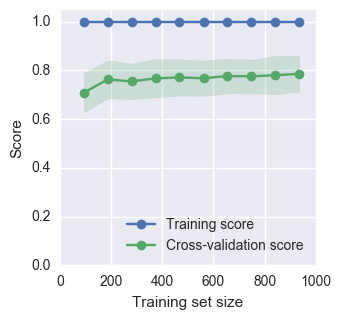

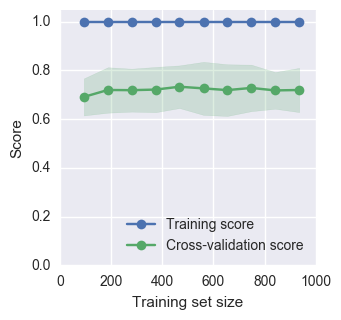

In [87]:
for peptide, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std in learning_curve_stats:
    
    # plot the learning curve
    plt.figure(figsize=(width, height))

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color=sns.color_palette()[0])
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color=sns.color_palette()[1])
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')

    plt.xlabel('Training set size')
    plt.ylabel('Score')

    plt.ylim(0.0, 1.05)

    plt.legend(loc='lower right')

    plt.savefig('learning_curve.pdf', bbox_inches='tight', dpi=600)